# CKME 136 - Twitter Sentiment Analysis

The goal of this project is to determine the best classifier using Tweets from Twitter to predict public sentiment surrounding the existence of global warming and climate change.
Yes will denote a positive sentiment supporting the claims of the existence of global warming and climate change. 
No will denote a negative sentiment denying the claims of the existence of global warming and climate change.

In [2]:
import pandas as pd #data manipulation
import numpy as np #data manipulation
import re #regex
import nltk #text processing
import matplotlib #visualisation
import matplotlib.cm as cm #visualisation
import matplotlib.pyplot as plt #visualisation
import seaborn as sns #visualisation
import warnings #ignore warnings
import string #string operations
import collections #for counter
warnings.filterwarnings('ignore') #ignore warnings
%matplotlib inline

In [3]:
#Importing the csv
raw = pd.read_csv('tweets_global.csv')

In [4]:
#First 5 entries in the dataset
raw.head(5)

,tweet,existence,existence.confidence
0,Global warming report urges governments to act...,Yes,1.0000
1,Fighting poverty and global warming in Africa ...,Yes,1.0000
2,Carbon offsets: How a Vatican forest failed to...,Yes,0.8786
3,Carbon offsets: How a Vatican forest failed to...,Yes,1.0000
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,Yes,0.8087


In [5]:
#Rows x Columns in dataset before data cleaning
raw.shape

(6090, 3)

In [6]:
#Checking for uniques in existence column
raw.existence.unique()

array(['Yes', nan, 'No', 'Y', 'N'], dtype=object)

existence
N      1031
No       46
Y      2467
Yes     437
Name: tweet, dtype: int64

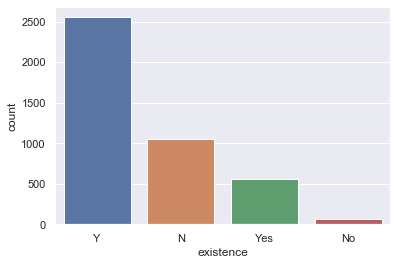

In [7]:
#Plotting for how many uniques in existence column
sns.set()
sns.countplot(raw.existence, order = raw.existence.value_counts().index);

#Grouping and counting how many tweets in each group
raw.groupby('existence')['tweet'].nunique()

In [8]:
#Data types
raw.dtypes

tweet                    object
existence                object
existence.confidence    float64
dtype: object

In [9]:
#descriptive stats
raw.describe()

,existence.confidence
count,6087.000000
mean,0.794478
std,0.180054
min,0.334600
25%,0.658500
50%,0.707600
75%,1.000000
max,1.000000


## Data Cleaning

The data has multiple issues in regards to the groupings with the existence column and they will have to be remapped accordingly so that we can better classify them later on. There are several N/A tweets that give us no information which have to removed from the data.

In [10]:
#Group and replace the N and Y to No and Yes
raw['existence'] = raw['existence'].replace('N','No')
raw['existence'] = raw['existence'].replace('Y','Yes')

#Checking if replaced
raw.groupby(['existence'])['tweet'].count()

existence
No     1114
Yes    3111
Name: tweet, dtype: int64

In [11]:
#Count how many NaN values in each column
raw.isnull().sum()

tweet                      0
existence               1865
existence.confidence       3
dtype: int64

In [12]:
#Dropping any NAs in the existence column
df = raw.dropna(subset=['existence'])

#Check if removed
df.isnull().sum()

tweet                   0
existence               0
existence.confidence    0
dtype: int64

In [13]:
#Check how many tweets are duplicates
df[df['tweet'].duplicated() == True].count()

tweet                   336
existence               336
existence.confidence    336
dtype: int64

In [14]:
#Dropping any duplicates in the tweet column
df.drop_duplicates(subset='tweet',keep=False, inplace=True)

#Check if removed
df[df['tweet'].duplicated() == True].count()

tweet                   0
existence               0
existence.confidence    0
dtype: int64

## Initial observations

To get an idea of what data I will be working with I created several graphs to show how many values are in each column for existence. I wanted to  understand if there were any initial relationships between the tweet lengths based on whether the tweet was denying or accepting the existence of global warming and climate change. I found that the lengths were similar for both groups and that were no patterns that could be derived.

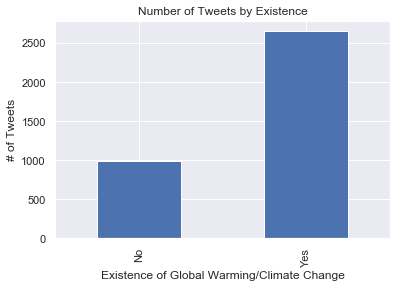

In [15]:
#Plotting a bar graph of the existence tweets (Yes/No)
#Ref: https://matplotlib.org/tutorials/introductory/pyplot.html
df.groupby('existence')['tweet'].nunique().plot(kind='bar')
plt.xlabel("Existence of Global Warming/Climate Change")
plt.ylabel("# of Tweets")
plt.title("Number of Tweets by Existence")
plt.show()

In [16]:
#Number of tweets values by existence
df.existence.value_counts()

Yes    2652
No      994
Name: existence, dtype: int64

In [17]:
#Calculate the lengths of the tweets
df['length'] = df.tweet.str.len()

112.77043335161821

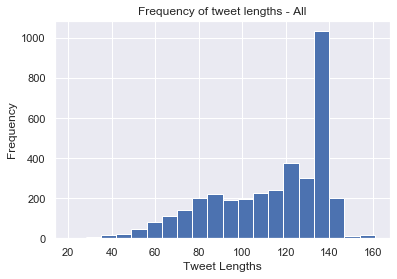

In [18]:
#Histogram - Frequency distribution of tweet lengths
plt.xlabel("Tweet Lengths")
plt.ylabel("# of Tweets")
plt.title("Frequency of tweet lengths - All")
df.length.plot.hist(bins=20)

#Average Length
df.length.mean()

112.4449472096531

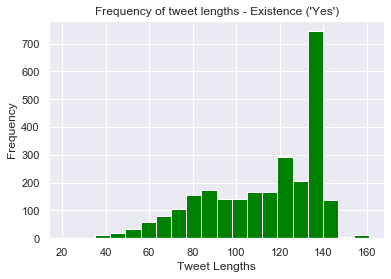

In [19]:
#Histogram - Frequency distribution of tweet lengths
#Existence = YES
plt.xlabel("Tweet Lengths")
plt.ylabel("# of Tweets")
plt.title("Frequency of tweet lengths - Existence ('Yes')")
df[df['existence'] == 'Yes'].length.plot.hist(bins=20, color='green')

#Average Length
df[df['existence'] == 'Yes'].length.mean()

113.63883299798793

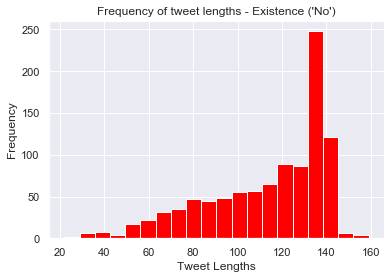

In [20]:
#Histogram - Frequency distribution of tweet lengths
#Existence = NO
plt.xlabel("Tweet Lengths")
plt.ylabel("# of Tweets")
plt.title("Frequency of tweet lengths - Existence ('No')")
df[df['existence'] == 'No'].length.plot.hist(bins=20,color = 'red')

#Average Length
df[df['existence'] == 'No'].length.mean()

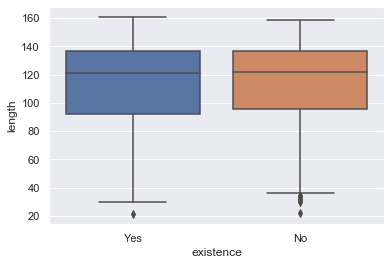

In [21]:
#Boxplot of the length of tweets by existence'
#Ref: https://seaborn.pydata.org/generated/seaborn.boxplot.html
ax = sns.boxplot(x="existence", y="length", data=df)

## Text preprocessing

I have to preprocess the tweets because they are not in a good format for NLP. I need to convert the tweets into raw text data first before I can apply any feature extraction method. I used RegEx to clean up a majority of common symbols, URLs and other words used unique to Twitter data.

In [22]:
#Text preprocessing - using regex
#Ref: https://docs.python.org/3/library/re.html
def preprocess(df,text):
    df[text] = df[text].str.lower() #make all lowercase
    df[text] = df[text].str.replace('http', '') #URLS
    df[text] = df[text].str.replace('@\S+', '') #mentions - must be first removal otherwise won't remove mentions
    df[text] = df[text].str.replace('[{}]'.format(string.punctuation), '') #remove punctuation
    df[text] = df[text].str.replace('\d+', '') #remove numbers
    df[text] = df[text].str.replace('rt', '') #remove rt
    df[text] = df[text].str.replace('link', '') #remove link
    df[text] = df[text].str.replace('via', '') #remove via
    df[text] = df[text].str.replace('new', '') #remove new
    df[text] = df[text].str.replace('news', '') #remove news
    df[text] = df[text].str.replace('\W', ' ') #remove symbols
    return df

In [23]:
#Applying text preprocessing function
df = preprocess(df,'tweet')

### Tokenization 

I used the Tweet Tokenization from the NLTK library because it was built specifically for Tweets. There is another general tokenizer from the NLTK library as well that could be utilized, but I chose to use this one instead. I need to convert the cleaned up raw text to tokens so they can be processed for NLP.

In [24]:
#Tweet Tokenization
#Ref: https://www.nltk.org/api/nltk.tokenize.html
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

In [25]:
#Applying tokenization
df['tweet'] = df['tweet'].apply(tknzr.tokenize)

### Stopwords 

I need to remove stop words which are common phrases which don't give us any meaningful information. I can manually update the stopwords to include other words from which I found did not add any value in the analysis.

In [26]:
#Removing Stopwords
#Ref: https://www.nltk.org/book/ch02.html
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.update(['dc','p','eah','say','us','get','could','like','go','snow'])

def remove_stopwords(text):
    text = [word for word in text if word not in stop]
    text = ' '.join(x for x in text)
    return text

In [27]:
#Applying the stopwords function
df['tweet'] = df['tweet'].apply(remove_stopwords)

### Stemming

I utilize stemming because it is regarded as being better for the text data I am dealing with. I use a different Stemmer called "Snowball" or Porter2 which is a better iteration of the original Porter Stemmer.

In [28]:
#Stemming
#Ref: https://www.nltk.org/howto/stem.html
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def stemm_words(text):
    text = [stemmer.stem(word) for word in text.split()]
    text = ' '.join(x for x in text)
    return text

In [29]:
#Applying stemming function
df['tweet'] = df['tweet'].apply(stemm_words)

### Frequency Distribution of Words - All Tweets

I wanted to get an idea of the frequency distribution of the words from all the tweets which I do below. This helps me better understand what words I can ignore/remove so I can get more useful insights or any words that I missed cleaning up in the preprocessing stage.

In [30]:
#Frequency Distribution of Words
#Ref: https://www.nltk.org/book/ch01.html
from nltk import FreqDist
fD_Stemmed = FreqDist(sum(df['tweet'].apply(tknzr.tokenize),[])).most_common()

In [31]:
#Create Dataframe for tweets with counts
commonwords = pd.DataFrame(fD_Stemmed, columns = ['Word' , 'Count']) 

In [32]:
#Showing Table of the 50 most common words
commonwords[:50]

,Word,Count
0,global,2105
1,climat,2037
2,warm,1995
3,chang,1866
4,tcot,156
5,scienc,139
6,green,135
7,repo,124
8,make,124
9,caus,121


### WordCloud and Top Frequent Words

I created a wordcloud for 3 different groupings. For all tweets, existence = yes tweets and existence = no tweets so that I can see the different word usage from all the different groups. Wordclouds are a good visualization representation to quickly observe patterns by the more frequency words being bigger. I also created a bar chart to get the top 10 words by frequency for each group to see how each group uses different words.

### All Tweets

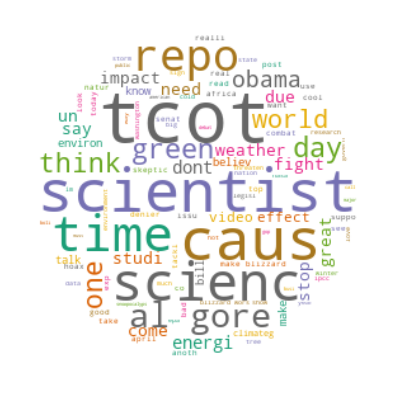

In [33]:
#Generating WordCloud - ALL tweets
#Ref: http://amueller.github.io/word_cloud/#
#Ref: https://www.datacamp.com/community/tutorials/wordcloud-python
from wordcloud import WordCloud, STOPWORDS

#Joining all tweets together
all_text = " ".join(tweet for tweet in df.tweet)

#Setting stopwords
stopwords = set(STOPWORDS)
stopwords.update(['global','warm','climat','chang'])

#Creating x, y coordinate grid
x, y = np.ogrid[:300, :300]

#Creating Mask
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wordcloud = WordCloud(width=1200, height=1200,stopwords=stopwords,mask=mask,background_color='white',colormap=matplotlib.cm.Dark2, max_words=100).generate(all_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [34]:
#Creating a bar chart of frequency of words in tweets
#Ref: https://towardsdatascience.com/identify-top-topics-using-word-cloud-9c54bc84d911
filtered_words = [word for word in all_text.split() if word not in stopwords]
word_freq_counts = collections.Counter(filtered_words)

#Creating arrays to keep track of word count
words = []
counts = []

In [35]:
#Looping through list of words and returning the most common elements
#Ref: https://kite.com/python/docs/collections.Counter.most_common
for letter, count in word_freq_counts.most_common(10):
    words.append(letter) #Add letter to word list
    counts.append(count) #Each count added to count list

<BarContainer object of 10 artists>

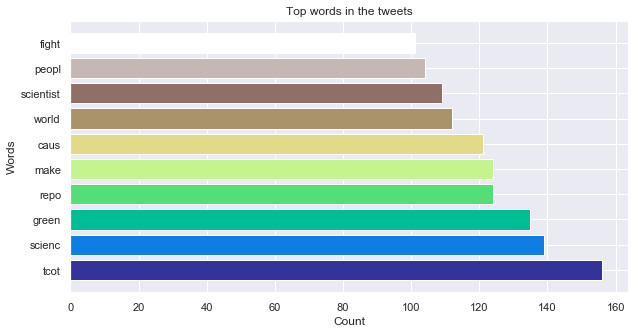

In [36]:
#Plotting barchart for most common words - ALL TWEETS
from matplotlib import rcParams

colors = cm.terrain(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 10, 5
plt.title('Top words in the tweets')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

### Existence = Yes Tweets

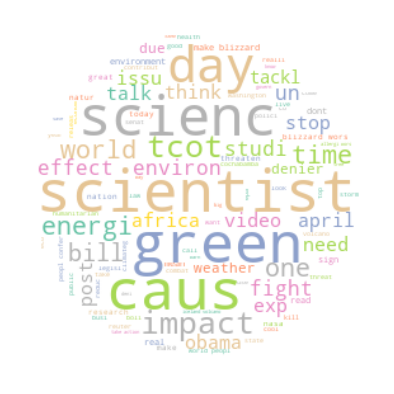

In [37]:
#Generating WordCloud Existence = 'YES'
#Ref: https://github.com/amueller/word_cloud
#Ref: https://www.datacamp.com/community/tutorials/wordcloud-python
#Setting existence only tweets
y_df = df[df['existence'] == 'Yes']

#Joining existence Yes tweets together
yes_text = " ".join(tweet for tweet in y_df.tweet)

#Updating stopwords
stopwords = set(STOPWORDS)
stopwords.update(['climat','global','warm','chang','say','us','repo'])

#Creating x, y coordinate grid
x, y = np.ogrid[:300, :300]

#Creating Mask
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wordcloud = WordCloud(width=1200, height=1200,stopwords=stopwords,mask=mask,background_color='white',colormap=matplotlib.cm.Set2, max_words=100).generate(yes_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [38]:
#Creating a bar chart of frequency of words in tweets
#Ref: https://towardsdatascience.com/identify-top-topics-using-word-cloud-9c54bc84d911
filtered_words = [word for word in yes_text.split() if word not in stopwords]
word_freq_counts = collections.Counter(filtered_words)

#Creating arrays to keep track of word count
words = []
counts = []

In [39]:
#Looping through list of words and returning the most common elements
#Ref: https://kite.com/python/docs/collections.Counter.most_common
for letter, count in word_freq_counts.most_common(10):
    words.append(letter) #Add letter to word list
    counts.append(count) #Each count added to count list

<BarContainer object of 10 artists>

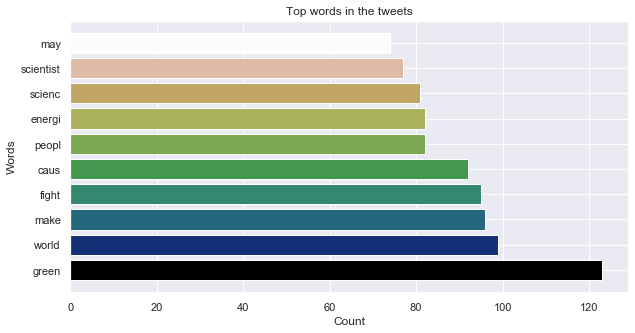

In [40]:
#Plotting barchart for most common words - YES TWEETS
from matplotlib import rcParams

colors = cm.gist_earth(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 10, 5
plt.title('Top words in the tweets')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

### Existence = No Tweets

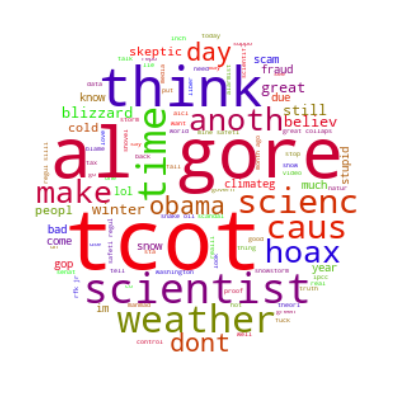

In [41]:
#Generating WordCloud - Existence = 'NO'
#Ref: https://github.com/amueller/word_cloud
#Ref: https://www.datacamp.com/community/tutorials/wordcloud-python
#Setting existence No tweets
n_df = df[df['existence'] == 'No']

#Joining all existence No tweets
no_text = " ".join(tweet for tweet in n_df.tweet)

#Updating stopwords
stopwords = set(STOPWORDS)
stopwords.update(['climat','global','warm','chang'])

#Creating x,y coordinate grid
x, y = np.ogrid[:300, :300]

#Creating mask
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wordcloud = WordCloud(width=1200, height=1200,stopwords=stopwords,mask=mask,background_color='white',colormap=matplotlib.cm.brg, max_words=100).generate(no_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [42]:
#Creating a bar chart of frequency of words in tweets
#Ref: https://towardsdatascience.com/identify-top-topics-using-word-cloud-9c54bc84d911
filtered_words = [word for word in no_text.split() if word not in stopwords]
word_freq_counts = collections.Counter(filtered_words)

#Creating arrays to keep track of word count
words = []
counts = []

In [43]:
#Looping through list of words and returning the most common elements
#Ref: https://kite.com/python/docs/collections.Counter.most_common
for letter, count in word_freq_counts.most_common(10):
    words.append(letter) #Add letter to word list
    counts.append(count) #Each count added to count list

<BarContainer object of 10 artists>

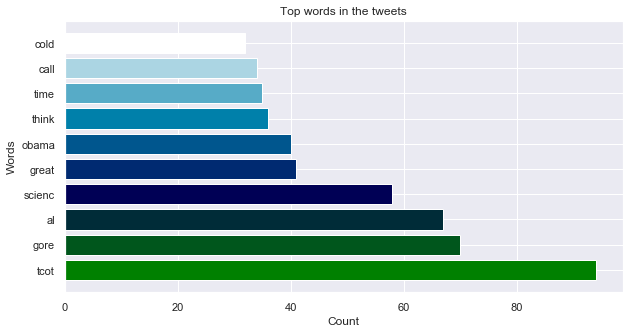

In [44]:
#Plotting barchart for most common words - NO TWEETS
from matplotlib import rcParams

colors = cm.ocean(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 10, 5
plt.title('Top words in the tweets')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

## Machine Learning

After performing EDA on the tweets I need to decide on feature extraction methods and what machine learning algorithmns I will be utilizing. In this case, I decide to use TF-IDF first then I will use Bag of Words using the same machine learning algorithmns. I will use SVM, Naive Bayes and Logistic Regression for the machine learning as they are the most widely used. I utilize the classification report to get all performance metrics which are accuracy, precision, recall and F1 Score. I am looking at the weighted metrics as it takes into account the class imbalance in the dataset. I also use a confusion matrix to show the results of the prediction.

In [45]:
#Creating Training and Test Set 80/20
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X = df['tweet']
y = df['existence']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 549)

In [46]:
#Utilizing TF-IDF to extract features
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

X_train_counts = tfidf_vectorizer.fit_transform(X_train)
X_test_counts = tfidf_vectorizer.transform(X_test)

## TF-IDF Method

### SVM

In [47]:
#SVM Classifier
#Ref: https://www.svm-tutorial.com/2014/10/svm-linear-kernel-good-text-classification/
from sklearn import svm
svm_c = svm.SVC(kernel='linear') #Using Linear Kernel

In [48]:
#Training the model with SVM
svm_c.fit(X_train_counts, y_train)

#Predicting the result
y_pred_counts = svm_c.predict(X_test_counts)

### SVM Results

In [49]:
#Main Classification Metrics
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_counts, digits=5))

              precision    recall  f1-score   support

          No    0.77181   0.58081   0.66282       198
         Yes    0.85714   0.93609   0.89488       532

    accuracy                        0.83973       730
   macro avg    0.81448   0.75845   0.77885       730
weighted avg    0.83400   0.83973   0.83194       730



In [50]:
#Confusion Matrix
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
from sklearn.metrics import confusion_matrix

#Ref: https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
#[TN,FP]
#[FN,TP]
conf = confusion_matrix(y_test, y_pred_counts)

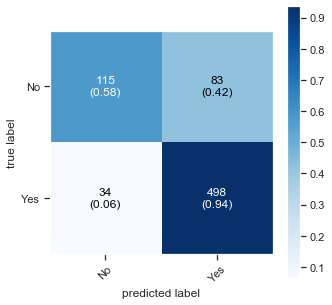

In [51]:
#Plotting Confusion Matrix
#Ref:http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/
from mlxtend.plotting import plot_confusion_matrix
class_names = ['No','Yes']
fig, ax = plot_confusion_matrix(conf_mat=conf,show_absolute=True,show_normed=True,class_names=class_names,colorbar=True,figsize =[(5),(5)])

#Necessary so the labels don't get cut off
plt.xlim(-0.5, len(np.unique(y))-0.5)
plt.ylim(len(np.unique(y))-0.5, -0.5)

plt.show()

## Logistic Regression

In [52]:
#Logistic Regression
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression
logistic_reg = LogisticRegression()

In [53]:
#Training the model with Logistic Regression
logistic_reg.fit(X_train_counts, y_train)

#Predicting the result
y_pred_counts=logistic_reg.predict(X_test_counts)

### Logistic Regression Results

In [54]:
#Main Classification Metrics
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_counts, digits=5))

              precision    recall  f1-score   support

          No    0.77000   0.38889   0.51678       198
         Yes    0.80794   0.95677   0.87608       532

    accuracy                        0.80274       730
   macro avg    0.78897   0.67283   0.69643       730
weighted avg    0.79765   0.80274   0.77862       730



In [55]:
#Confusion Matrix
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, y_pred_counts)

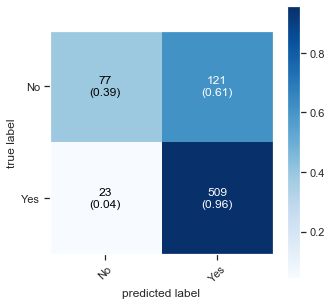

In [56]:
#Plotting Confusion Matrix
#Ref:http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/
from mlxtend.plotting import plot_confusion_matrix
class_names = ['No','Yes']
fig, ax = plot_confusion_matrix(conf_mat=conf,show_absolute=True,show_normed=True,class_names=class_names,colorbar=True,figsize =[(5),(5)])

#Necessary so the labels don't get cut off
plt.xlim(-0.5, len(np.unique(y))-0.5)
plt.ylim(len(np.unique(y))-0.5, -0.5)

plt.show()

## Naive Bayes

In [57]:
#Naive Bayes classifier 
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
from sklearn.naive_bayes import MultinomialNB
naive_bay = MultinomialNB()

In [58]:
#Training the model
naive_bay.fit(X_train_counts, y_train)

#Predicting the result
y_pred_counts=naive_bay.predict(X_test_counts)

### Naive Bayes Results

In [59]:
#Main Classification Metrics
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_counts, digits=5))

              precision    recall  f1-score   support

          No    0.95556   0.21717   0.35391       198
         Yes    0.77372   0.99624   0.87099       532

    accuracy                        0.78493       730
   macro avg    0.86464   0.60671   0.61245       730
weighted avg    0.82304   0.78493   0.73074       730



In [60]:
#Confusion Matrix
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, y_pred_counts)

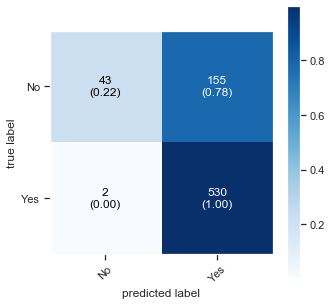

In [61]:
#Plotting Confusion Matrix
#Ref:http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/
from mlxtend.plotting import plot_confusion_matrix
class_names = ['No','Yes']
fig, ax = plot_confusion_matrix(conf_mat=conf,show_absolute=True,show_normed=True,class_names=class_names,colorbar=True,figsize =[(5),(5)])

#Necessary so the labels don't get cut off
plt.xlim(-0.5, len(np.unique(y))-0.5)
plt.ylim(len(np.unique(y))-0.5, -0.5)

plt.show()

## Bag of Words Method

In [62]:
#Utilizing Bag of Words to extract features
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

## SVM

In [63]:
#SVM Classifier
#Ref: https://www.svm-tutorial.com/2014/10/svm-linear-kernel-good-text-classification/
from sklearn import svm
svm_c = svm.SVC(kernel='linear') #Using Linear Kernel

In [64]:
#Training the model with SVM
svm_c.fit(X_train_counts, y_train)

#Predicting the result
y_pred_counts = svm_c.predict(X_test_counts)

### SVM Results

In [65]:
#Main Classification Metrics
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_counts, digits=5))

              precision    recall  f1-score   support

          No    0.71023   0.63131   0.66845       198
         Yes    0.86823   0.90414   0.88582       532

    accuracy                        0.83014       730
   macro avg    0.78923   0.76772   0.77713       730
weighted avg    0.82538   0.83014   0.82686       730



In [66]:
#Confusion Matrix
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, y_pred_counts)

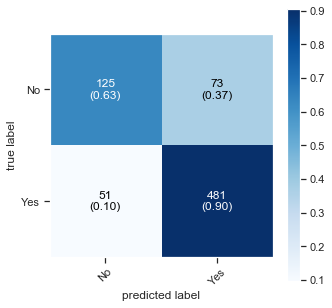

In [67]:
#Plotting Confusion Matrix
#Ref:http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/
from mlxtend.plotting import plot_confusion_matrix
class_names = ['No','Yes']
fig, ax = plot_confusion_matrix(conf_mat=conf,show_absolute=True,show_normed=True,class_names=class_names,colorbar=True,figsize =[(5),(5)])

#Necessary so the labels don't get cut off
plt.xlim(-0.5, len(np.unique(y))-0.5)
plt.ylim(len(np.unique(y))-0.5, -0.5)

plt.show()

## Logistic Regression

In [68]:
#Logistic Regression
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression
logistic_reg = LogisticRegression()

In [69]:
#Training the model with Logistic Regression
logistic_reg.fit(X_train_counts, y_train)

#Predicting the result
y_pred_counts=logistic_reg.predict(X_test_counts)

### Logistic Regression Results

In [70]:
#Main Classification Metrics
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_counts, digits=5))

              precision    recall  f1-score   support

          No    0.76224   0.55051   0.63930       198
         Yes    0.84838   0.93609   0.89008       532

    accuracy                        0.83151       730
   macro avg    0.80531   0.74330   0.76469       730
weighted avg    0.82502   0.83151   0.82206       730



In [71]:
#Confusion Matrix
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, y_pred_counts)

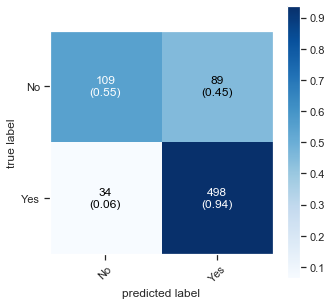

In [72]:
#Plotting Confusion Matrix
#Ref:http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/
from mlxtend.plotting import plot_confusion_matrix
class_names = ['No','Yes']
fig, ax = plot_confusion_matrix(conf_mat=conf,show_absolute=True,show_normed=True,class_names=class_names,colorbar=True,figsize =[(5),(5)])

#Necessary so the labels don't get cut off
plt.xlim(-0.5, len(np.unique(y))-0.5)
plt.ylim(len(np.unique(y))-0.5, -0.5)

plt.show()

## Naive Bayes

In [73]:
#Naive Bayes classifier 
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
from sklearn.naive_bayes import MultinomialNB
naive_bay = MultinomialNB()

In [74]:
#Training the model
naive_bay.fit(X_train_counts, y_train)

#Predicting the result
y_pred_counts=naive_bay.predict(X_test_counts)

### Naive Bayes Results

In [75]:
#Main Classification Metrics
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_counts, digits=5))

              precision    recall  f1-score   support

          No    0.68927   0.61616   0.65067       198
         Yes    0.86257   0.89662   0.87926       532

    accuracy                        0.82055       730
   macro avg    0.77592   0.75639   0.76496       730
weighted avg    0.81556   0.82055   0.81726       730



In [76]:
#Confusion Matrix
#Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, y_pred_counts)

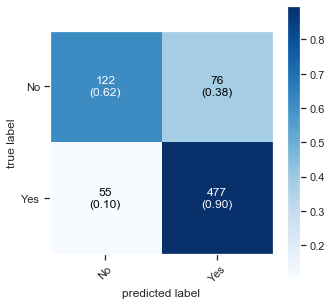

In [77]:
#Plotting Confusion Matrix
#Ref:http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/
from mlxtend.plotting import plot_confusion_matrix
class_names = ['No','Yes']
fig, ax = plot_confusion_matrix(conf_mat=conf,show_absolute=True,show_normed=True,class_names=class_names,colorbar=True,figsize =[(5),(5)])

#Necessary so the labels don't get cut off
plt.xlim(-0.5, len(np.unique(y))-0.5)
plt.ylim(len(np.unique(y))-0.5, -0.5)

plt.show()

### Conclusion  and Future work

In future, I would like to experiment  using a neural network or unsupervised method to try to label the unlabeled data because they made up a majority of the dataset. A lot of data was missing as a result of the removing all the unlabeled data. I would like to grab data directly from the Twitter API because the current dataset is good, but doesn't offer the same granularity with data on likes and retweets. More useful patterns and relationships could be better understood by getting all the data directly from Twitter. Overall, I am satisfied with the project results and approach.

#### References

Afham, M. (2019, October 27). Twitter Sentiment Analysis Classification using NLTK, Python. Retrieved from https://towardsdatascience.com/twitter-sentiment-analysis-classification-using-nltk-python-fa912578614c

Bhanot, K. (2019, January 17). Identify Top Topics using Word Cloud. Retrieved from https://towardsdatascience.com/identify-top-topics-using-word-cloud-9c54bc84d911

Code Faster with Line-of-Code Completions, Cloudless Processing. (n.d.). Retrieved from https://kite.com/python/docs/collections.Counter.most_common

KOWALCZYKI, A. (2018, November 14). Linear Kernel: Why is it recommended for text classification ? Retrieved from https://www.svm-tutorial.com/2014/10/svm-linear-kernel-good-text-classification/

Kub, A. (2019, January 29). Sentiment Analysis with Python (Part 1). Retrieved from https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184

Lazar, D. (2020, February 9). Building a Sentiment Classifier using Scikit-Learn. Retrieved from https://towardsdatascience.com/building-a-sentiment-classifier-using-scikit-learn-54c8e7c5d2f0

Markham, K. (2020, February 3). Simple guide to confusion matrix terminology. Retrieved from https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

nltk.tokenize package. (n.d.). Retrieved from https://www.nltk.org/api/nltk.tokenize.html

Pyplot tutorial. (n.d.). Retrieved from https://matplotlib.org/tutorials/introductory/pyplot.html

Raschka, S. (n.d.). Confusion Matrix. Retrieved from http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

re - Regular expression operations. (n.d.). Retrieved from https://docs.python.org/3/library/re.html

seaborn.boxplot. (n.d.). Retrieved from https://seaborn.pydata.org/generated/seaborn.boxplot.html

Shreyas, P. (2019, November 26). Tweet analytics using NLP. Retrieved from https://towardsdatascience.com/tweet-analytics-using-nlp-f83b9f7f7349

sklearn.metrics.confusion_matrix. (n.d.). Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix

(Tutorial) Generate Word Clouds in Python. (n.d.). Retrieved from https://www.datacamp.com/community/tutorials/wordcloud-python

Wolff, R. (2020, March 9). Quick Introduction to Sentiment Analysis. Retrieved from https://towardsdatascience.com/quick-introduction-to-sentiment-analysis-74bd3dfb536c

WordCloud for Python documentation. (n.d.). Retrieved from http://amueller.github.io/word_cloud/#